#Wildfire Burned Area Prediction using Dask and Random Forest

**Module**: ITS66604-MLPC – Machine Learning with Parallel Computing  
**Student Name**: Rishav Dhakal  
**Assignment Type**: Individual  
**Submission Date**: July 2025

In [1]:
# Install Dask
!pip install --quiet dask

# Import required libraries
import pandas as pd
import dask.dataframe as dd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Enable visualizations inline
%matplotlib inline


In [2]:
import dask.dataframe as dd

# Update the path to your actual file location
file_path = '/content/drive/MyDrive/datasets/forestfires.csv'

# Load the dataset using Dask, specifying the dtype for 'area'
df_dask = dd.read_csv('/content/drive/MyDrive/MLPCIndividual/forestfires.csv', dtype={'area': 'float64'})

# Preview the data
df_dask.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
# Convert 'month' and 'day' from string to categorical codes
df_dask = df_dask.categorize(columns=['month', 'day'])
df_dask['month'] = df_dask['month'].cat.codes
df_dask['day'] = df_dask['day'].cat.codes

# Drop any missing values
df_dask = df_dask.dropna()

# Convert Dask DataFrame to pandas DataFrame for use in scikit-learn
df = df_dask.compute()

# Preview cleaned data
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
# Define features (X) and target variable (y)
X = df.drop(columns=['area'])  # All columns except 'area'
y = df['area']                 # The column we want to predict

# Split into training and testing datasets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Show the shape of each set
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (413, 12)
Testing set shape: (104, 12)


In [11]:
from sklearn.ensemble import RandomForestRegressor
import time

# Start the timer
start_time = time.time()

# Create and train the model (using all CPU cores)
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# End the timer
train_time = time.time() - start_time
print(f" Training completed in {train_time:.2f} seconds.")


Baseline model training completed in 0.97 seconds.
Fitting 3 folds for each of 12 candidates, totalling 36 fits
GridSearchCV training completed in 19.70 seconds.
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print(f"📏 Mean Absolute Error (MAE): {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")


 Mean Absolute Error (MAE): 27.54
 Root Mean Squared Error (RMSE): 109.96
 R² Score: -0.03


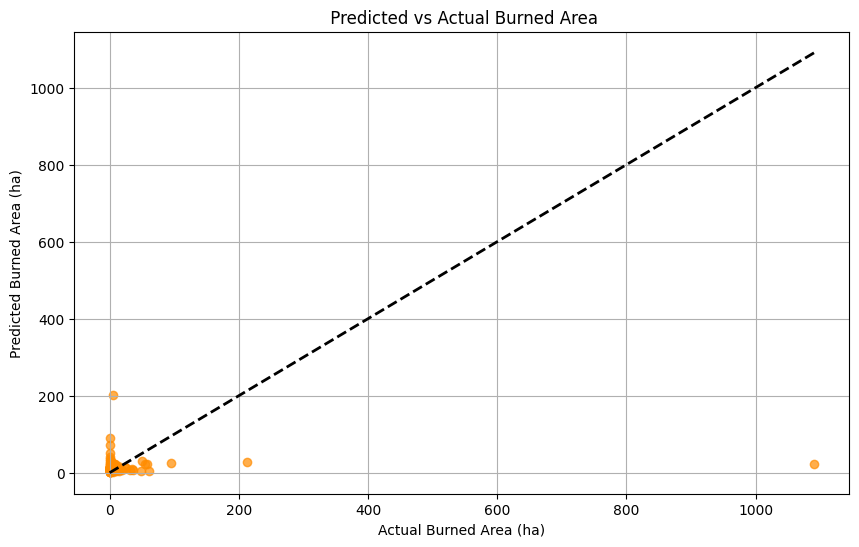

In [7]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Burned Area (ha)")
plt.ylabel("Predicted Burned Area (ha)")
plt.title(" Predicted vs Actual Burned Area")
plt.grid(True)
plt.show()


In [8]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'wildfire_rf_model.joblib')

print(" Model saved successfully as 'wildfire_rf_model.joblib'")


 Model saved successfully as 'wildfire_rf_model.joblib'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


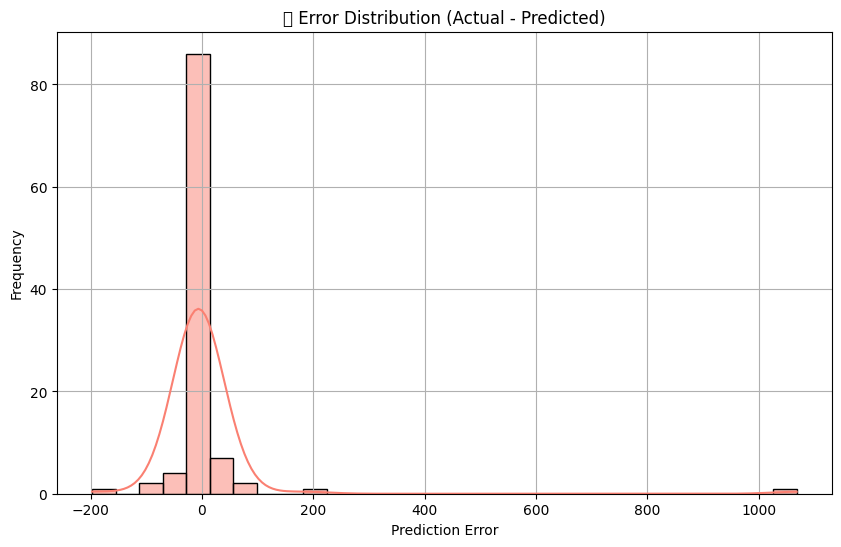

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate prediction errors
errors = y_test - y_pred

# Plot error distribution
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True, color='salmon')
plt.title("📉 Error Distribution (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

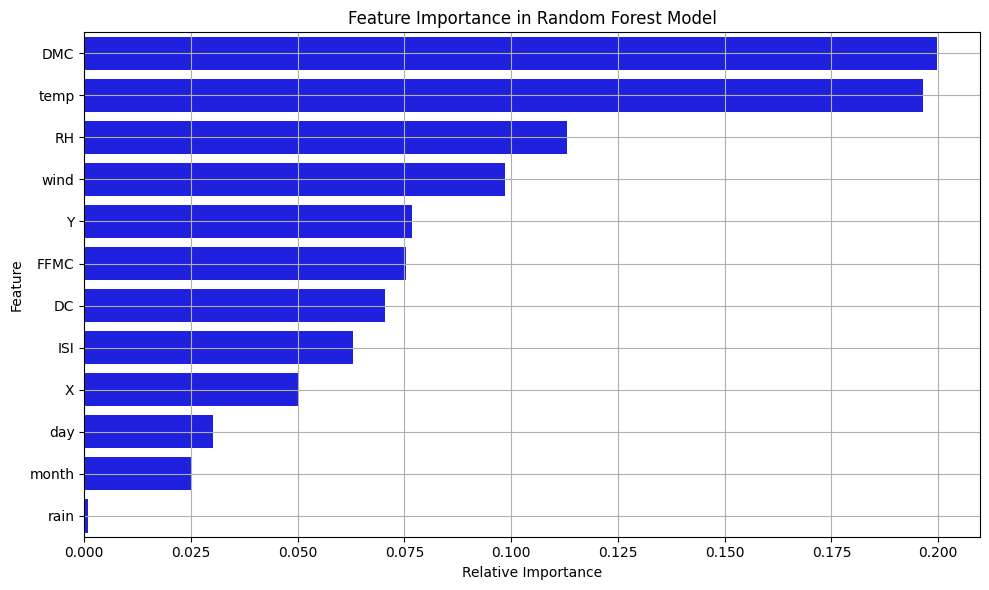

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df, x='Importance', y='Feature', color='blue')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
from sklearn.ensemble import RandomForestRegressor
import time

# Train with parallelism (n_jobs=-1)
start_parallel = time.time()
model_parallel = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model_parallel.fit(X_train, y_train)
time_parallel = time.time() - start_parallel

# Train without parallelism (n_jobs=1)
start_nonparallel = time.time()
model_nonparallel = RandomForestRegressor(n_estimators=100, n_jobs=1, random_state=42)
model_nonparallel.fit(X_train, y_train)
time_nonparallel = time.time() - start_nonparallel

# Print the comparison
print(" Training Time Comparison:")
print(f" With Parallelism (n_jobs=-1): {time_parallel:.2f} seconds")
print(f" Without Parallelism (n_jobs=1): {time_nonparallel:.2f} seconds")


 Training Time Comparison:
 With Parallelism (n_jobs=-1): 0.50 seconds
 Without Parallelism (n_jobs=1): 0.49 seconds
